# EIS DEM Inversion

In [83]:
import asdf
import astropy.table
import astropy.units as u
import eispac.core
import matplotlib.pyplot as plt
import ndcube
import numpy as np
import pathlib
import fiasco
import sunpy.map

from astropy.visualization import ImageNormalize, LogStretch, quantity_support
from astropy.nddata import StdDevUncertainty

from sunkit_dem import Model

import sys
sys.path.append('../scripts')
from dem import HK12Model, write_cube_with_xarray, make_slope_map, read_cube_with_xarray

## Contribution Functions

The first thing we need to do is, for each line we want to observe, we need to compute the corresponding contribution function for each line.

In [2]:
line_table = astropy.table.QTable.read('../data/tables/selected_eis_lines.asdf')

In [3]:
line_table[6:]

<QTable length=15>
Element   Z   ... Number Gaussians               Included lines              
              ...                                                            
  str2  int64 ...      int64                         str89                   
------- ----- ... ---------------- ------------------------------------------
     Ca    20 ...                2            Ca XVI 208.604, Fe XIII 208.679
     Ca    20 ...                1                            Ca XVII 192.858
     Fe    26 ...                3 Fe IX 188.497, S XI 188.675, Ar XI 188.806
     Fe    26 ...                1                              Fe IX 197.862
     Fe    26 ...                1                               Fe X 184.536
     Fe    26 ...                1                              Fe XI 180.401
     Fe    26 ...                2               Fe XI 188.216, Fe XI 188.299
     Fe    26 ...                1                             Fe XII 192.394
     Fe    26 ...                2             Fe XII 195.119, Fe XII 195.179
     Fe    26 ...                1                            Fe XIII 202.044
     Fe    26 ...                2            Fe XII 203.720, Fe XIII 203.826
     Fe    26 ...                1                             Fe XIV 264.787
     Fe    26 ...                2              Mg VI 270.394, Fe XIV 270.519
     Fe    26 ...                2               Al IX 284.015, Fe XV 284.160
     Fe    26 ...                1                             Fe XVI 262.984

In [4]:
delta_log_T = 0.02
temperature = 10**np.arange(5.0, 7.3+delta_log_T, delta_log_T)*u.K
density = 1e9*u.cm**(-3)  #1e15*u.Unit('K cm-3') / temperature
selected_ions = {name: fiasco.Ion(name, temperature)
                 for name in np.unique([f'{r["Element"]} {r["Ion"]}' for r in line_table])}

In [5]:
contribution_functions = {k: v.contribution_function(density, couple_density_to_temperature=False)
                          for k,v in selected_ions.items()}

In [6]:
goft = []
for row in line_table:
    key = f'{row["Element"]} {row["Ion"]}'
    _ion = selected_ions[key]
    _transitions =  _ion.transitions.wavelength[~_ion.transitions.is_twophoton]
    i_min = np.argmin(np.fabs(_transitions - row['Wavelength']))
    #print(key, _transitions[i_min], row['Wavelength'])
    goft.append(contribution_functions[key][:,0,i_min]/(4*np.pi*u.steradian))
goft = u.Quantity(goft)
line_table['Contribution Function'] = goft
line_table['Temperature Contribution Function'] = u.Quantity(len(line_table)*[temperature])
line_table['Include in DEM Analysis'] = True
# Dropping these lines
dropped_lines = [
    #'si_07_275_368.3c',
    's__10_264_233.1c',
    's__13_256_686.1c',
    #'ca_14_193_874.6c',
    #'ca_15_200_972.2c',
    'ca_16_208_604.2c',
    'ca_17_192_858.1c',
    'fe_09_188_497.3c',
    'fe_09_197_862.1c',
    'fe_16_262_984.1c',
]
col = line_table['Include in DEM Analysis']
for d in dropped_lines:
    col[line_table['Template'] == f'{d}.template.h5'] = False
line_table['Include in DEM Analysis'] = col

In [7]:
line_table.write('../data/tables/selected_eis_lines_goft.asdf')

Can skip everything above this

In [2]:
line_table = astropy.table.QTable.read('../data/tables/selected_eis_lines_goft.asdf')

(1e-27, 5e-24)

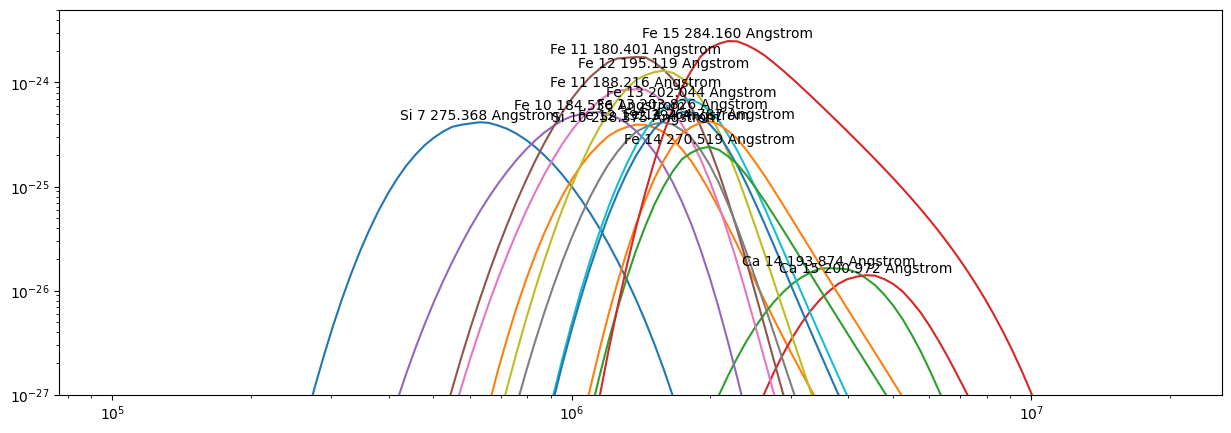

In [8]:
plt.figure(figsize=(15,5))
for r in line_table:
    if r['Include in DEM Analysis']:
        plt.plot(
            r['Temperature Contribution Function'],
            r['Contribution Function'],
        )
        imax = np.argmax(r['Contribution Function'])
        plt.text(r['Temperature Contribution Function'][imax].value,
                 r['Contribution Function'][imax].value,
                 f'{r["Element"]} {r["Ion"]} {r["Wavelength"]:.3f}',
                 va='bottom',
                 ha='center')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-27, 5e-24)
#plt.legend(ncol=5, loc=3)

## Building Data Structures

In [9]:
def maps_to_collection(root_dir, table, mask_value=0.0, error_percentage=0.1):
    """
    Take a directory of FITS files and a line table and build a collection of cubes
    from those maps.

    Parameters
    ----------
    root_dir
    table

    Returns
    -------
    collection
    """
    collection = []
    root_dir = pathlib.Path(root_dir)
    for row in table:
        if not row['Include in DEM Analysis']:
            continue
        line_label = '.'.join(row['Template'].split('.')[:-2])
        if len(filename := list(root_dir.glob(f'eis_*.{line_label}-*.int.fits'))) == 0:
            print(f'No data available for {line_label} in {root_dir}.')
            continue
        if len(filename) > 1:
            print(f'Multiple filenames found for {line_label}:\n{filename}')
        m = sunpy.map.Map(filename[0])
        m.mask = m.data == mask_value
        uncertainty = StdDevUncertainty(error_percentage*m.quantity)
        cube = ndcube.NDCube(m.data,
                             wcs=m.wcs,
                             meta=m.meta,
                             unit=m.unit,
                             mask=m.mask,
                             uncertainty=uncertainty)
        collection.append((line_label, cube))
    collection = ndcube.NDCollection(collection, aligned_axes=(0,1),)
    return collection

In [10]:
collection_11944 = maps_to_collection('../data/noaa_11944/EIS/level_2.5/', line_table, error_percentage=0.2)
collection_11967 = maps_to_collection('../data/noaa_11967/EIS/level_2.5/', line_table, error_percentage=0.2)
collection_11990 = maps_to_collection('../data/noaa_11990/EIS/level_2.5/', line_table, error_percentage=0.2)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Miss

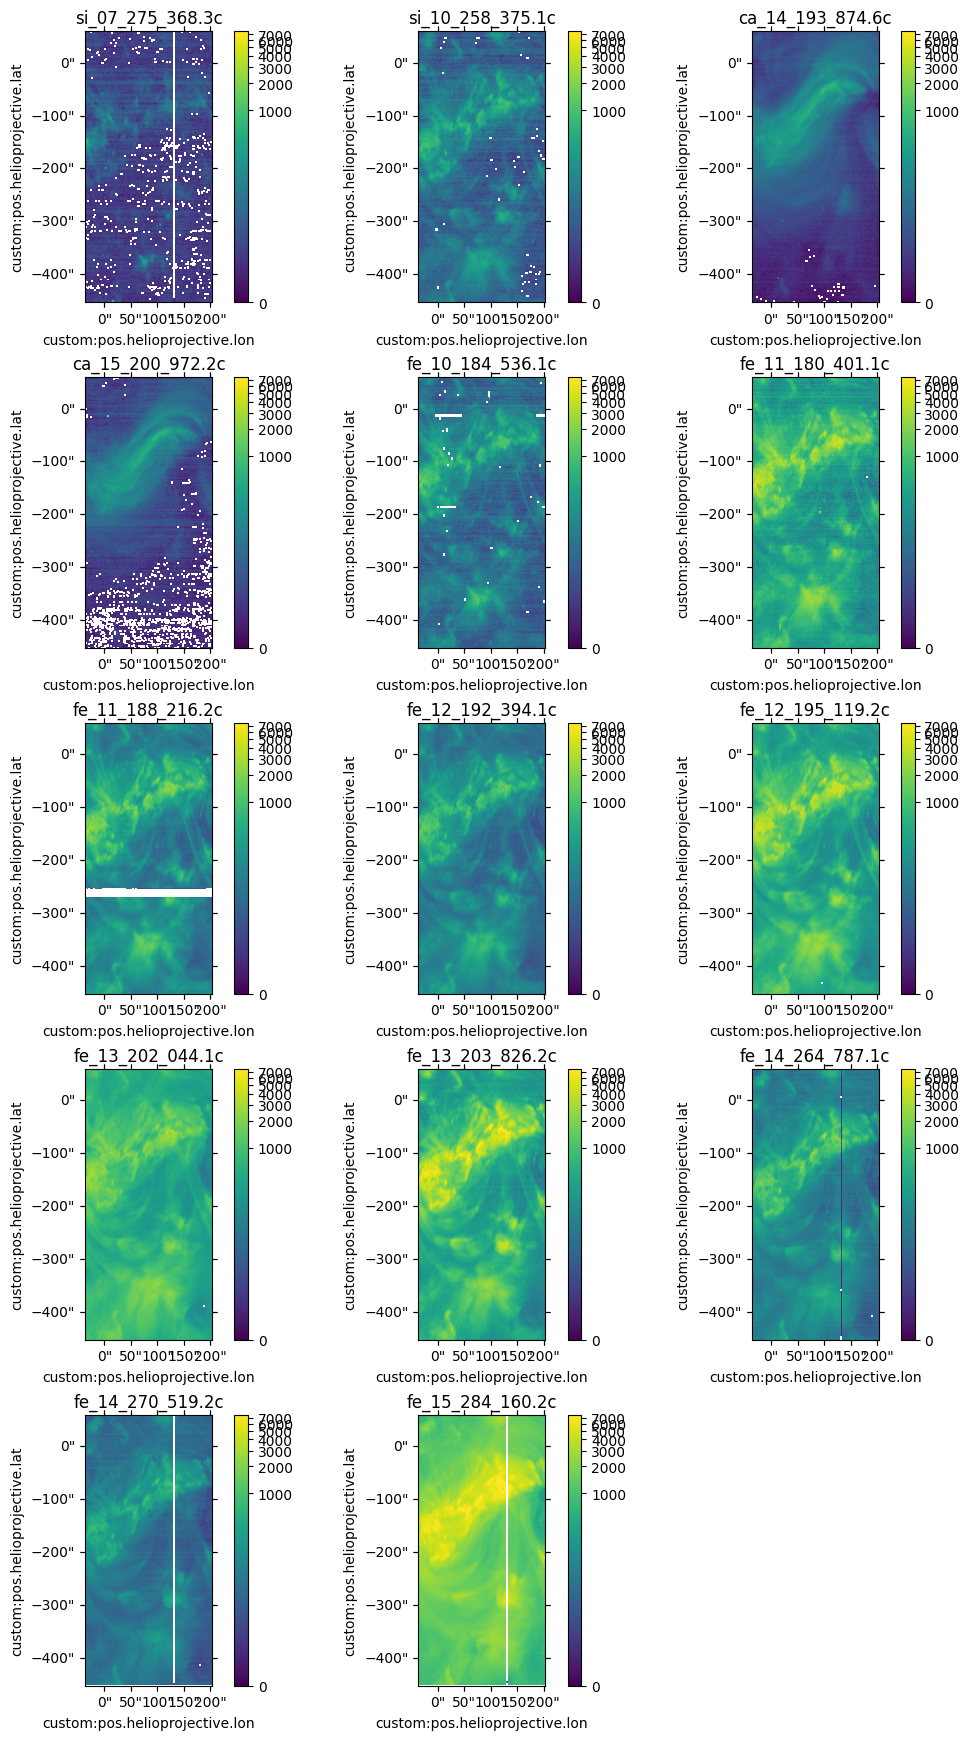

In [14]:
fig = plt.figure(figsize=(10,20),layout='constrained')
norm = ImageNormalize(vmin=0,vmax=7.5e3,stretch=LogStretch())
for i,(k,v) in enumerate(collection_11944.items()):
    ax = fig.add_subplot(6,3,i+1,projection=v.wcs)
    v.plot(axes=ax,norm=norm)
    ax.set_aspect(0.5)
    ax.set_title(k)
    fig.colorbar(ax.get_images()[0], ax=ax)

Note that when inverting, we need to select only the kernels for which there are observations in that collection.

## Inversion

In [81]:
ar_table = astropy.table.QTable.read('../data/tables/mason_ars_region_1.asdf')

In [23]:
kernels = {'.'.join(r['Template'].split('.')[:-2]): r['Contribution Function'] for r in line_table}

In [24]:
delta_log_t = 0.1
temperature_bin_edges = 10**np.arange(5.5, 7.2+delta_log_t, delta_log_t) * u.K

In [72]:
dem_settings = {
    'alpha': 1.0,
    'increase_alpha': 1.5,
    'max_iterations': 100,
    'use_em_loci': False,
    'emd_int': False,
    'l_emd': False,
    'guess': 1,
}
slope_fitting_params = {
    'temperature_bounds': (.9,3)*u.MK,
    'em_threshold': 1e22*u.cm**(-5),
    'rsquared_tolerance': 0.4,
}

In [69]:
root_dir = pathlib.Path('../data/')

In [84]:
for row in ar_table:
    print(row['NOAA AR'])
    top_dir = root_dir / f'noaa_{row["NOAA AR"]}'
    em_dir = top_dir / 'diagnostics' / 'dem'
    em_dir.mkdir(exist_ok=True, parents=True)
    _collection = maps_to_collection(top_dir / 'EIS' / 'level_2.5',
                                     line_table,
                                     mask_value=0.0,
                                     error_percentage=0.2)
    dem_model = Model(_collection,
                      {k:v for k,v in kernels.items() if k in _collection},
                      temperature_bin_edges,
                      kernel_temperatures=line_table['Temperature Contribution Function'][0],
                      model='hk12')
    dem_res = dem_model.fit(**dem_settings)
    dem_res['em'].mask = dem_res['dem'].mask
    write_cube_with_xarray(dem_res['em'],
                           'temperature',
                           em_dir / f'em_noaa{row["NOAA AR"]}_eis.nc')
    slope_map = make_slope_map(dem_res['em'], **slope_fitting_params)
    with asdf.AsdfFile({'slope_map': slope_map}) as asdf_file:
        asdf_file.write_to(em_dir / f'emslope_noaa{row["NOAA AR"]}_eis.asdf')

11944
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO

/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/dn2dem.py:181: RuntimeWarning: divide by zero encountered in log10
  tr[:,i]=10**np.interp(logt,tresp_logt,np.log10(truse[:,i]))
  0%|                                                                                                                    | 0.00/614 [00:00<?, ? x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: invalid value encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-p

11967
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO

/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/dn2dem.py:181: RuntimeWarning: divide by zero encountered in log10
  tr[:,i]=10**np.interp(logt,tresp_logt,np.log10(truse[:,i]))
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: invalid value encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
  0%|                                                 

11990
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
No data available for si_10_258_375.1c in ../data/noaa_11990/EIS/level_2.5.
No data available for ca_14_193_874.6c in ../data/noaa_11990/EIS/level_2.5.
No data available for ca_15_200_972.2c in ../data/noaa_11990/EIS/level_2.5.
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
No data available for fe_11_180_401.1c in ../data/noaa_11990/EIS/level_2.5.
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for sol

/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/dn2dem.py:181: RuntimeWarning: divide by zero encountered in log10
  tr[:,i]=10**np.interp(logt,tresp_logt,np.log10(truse[:,i]))
  0%|                                                                                                                    | 0.00/120 [00:00<?, ? x10^2 DEM/s]/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:198: RuntimeWarning: divide by zero encountered in divide
  rmatrixin[:,kk]=rmatrix[:,kk]/ednin[kk]
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:199: RuntimeWarning: invalid value encountered in divide
  dn=dnin/ednin
/Users/wtbarnes/mambaforge/envs/loops-2024-talk/lib/python3.12/site-packages/demregpy/demmap.py:200: RuntimeWarning: invalid value encountered in divide
  edn=ednin/ednin
  1%|▉                                                                                       

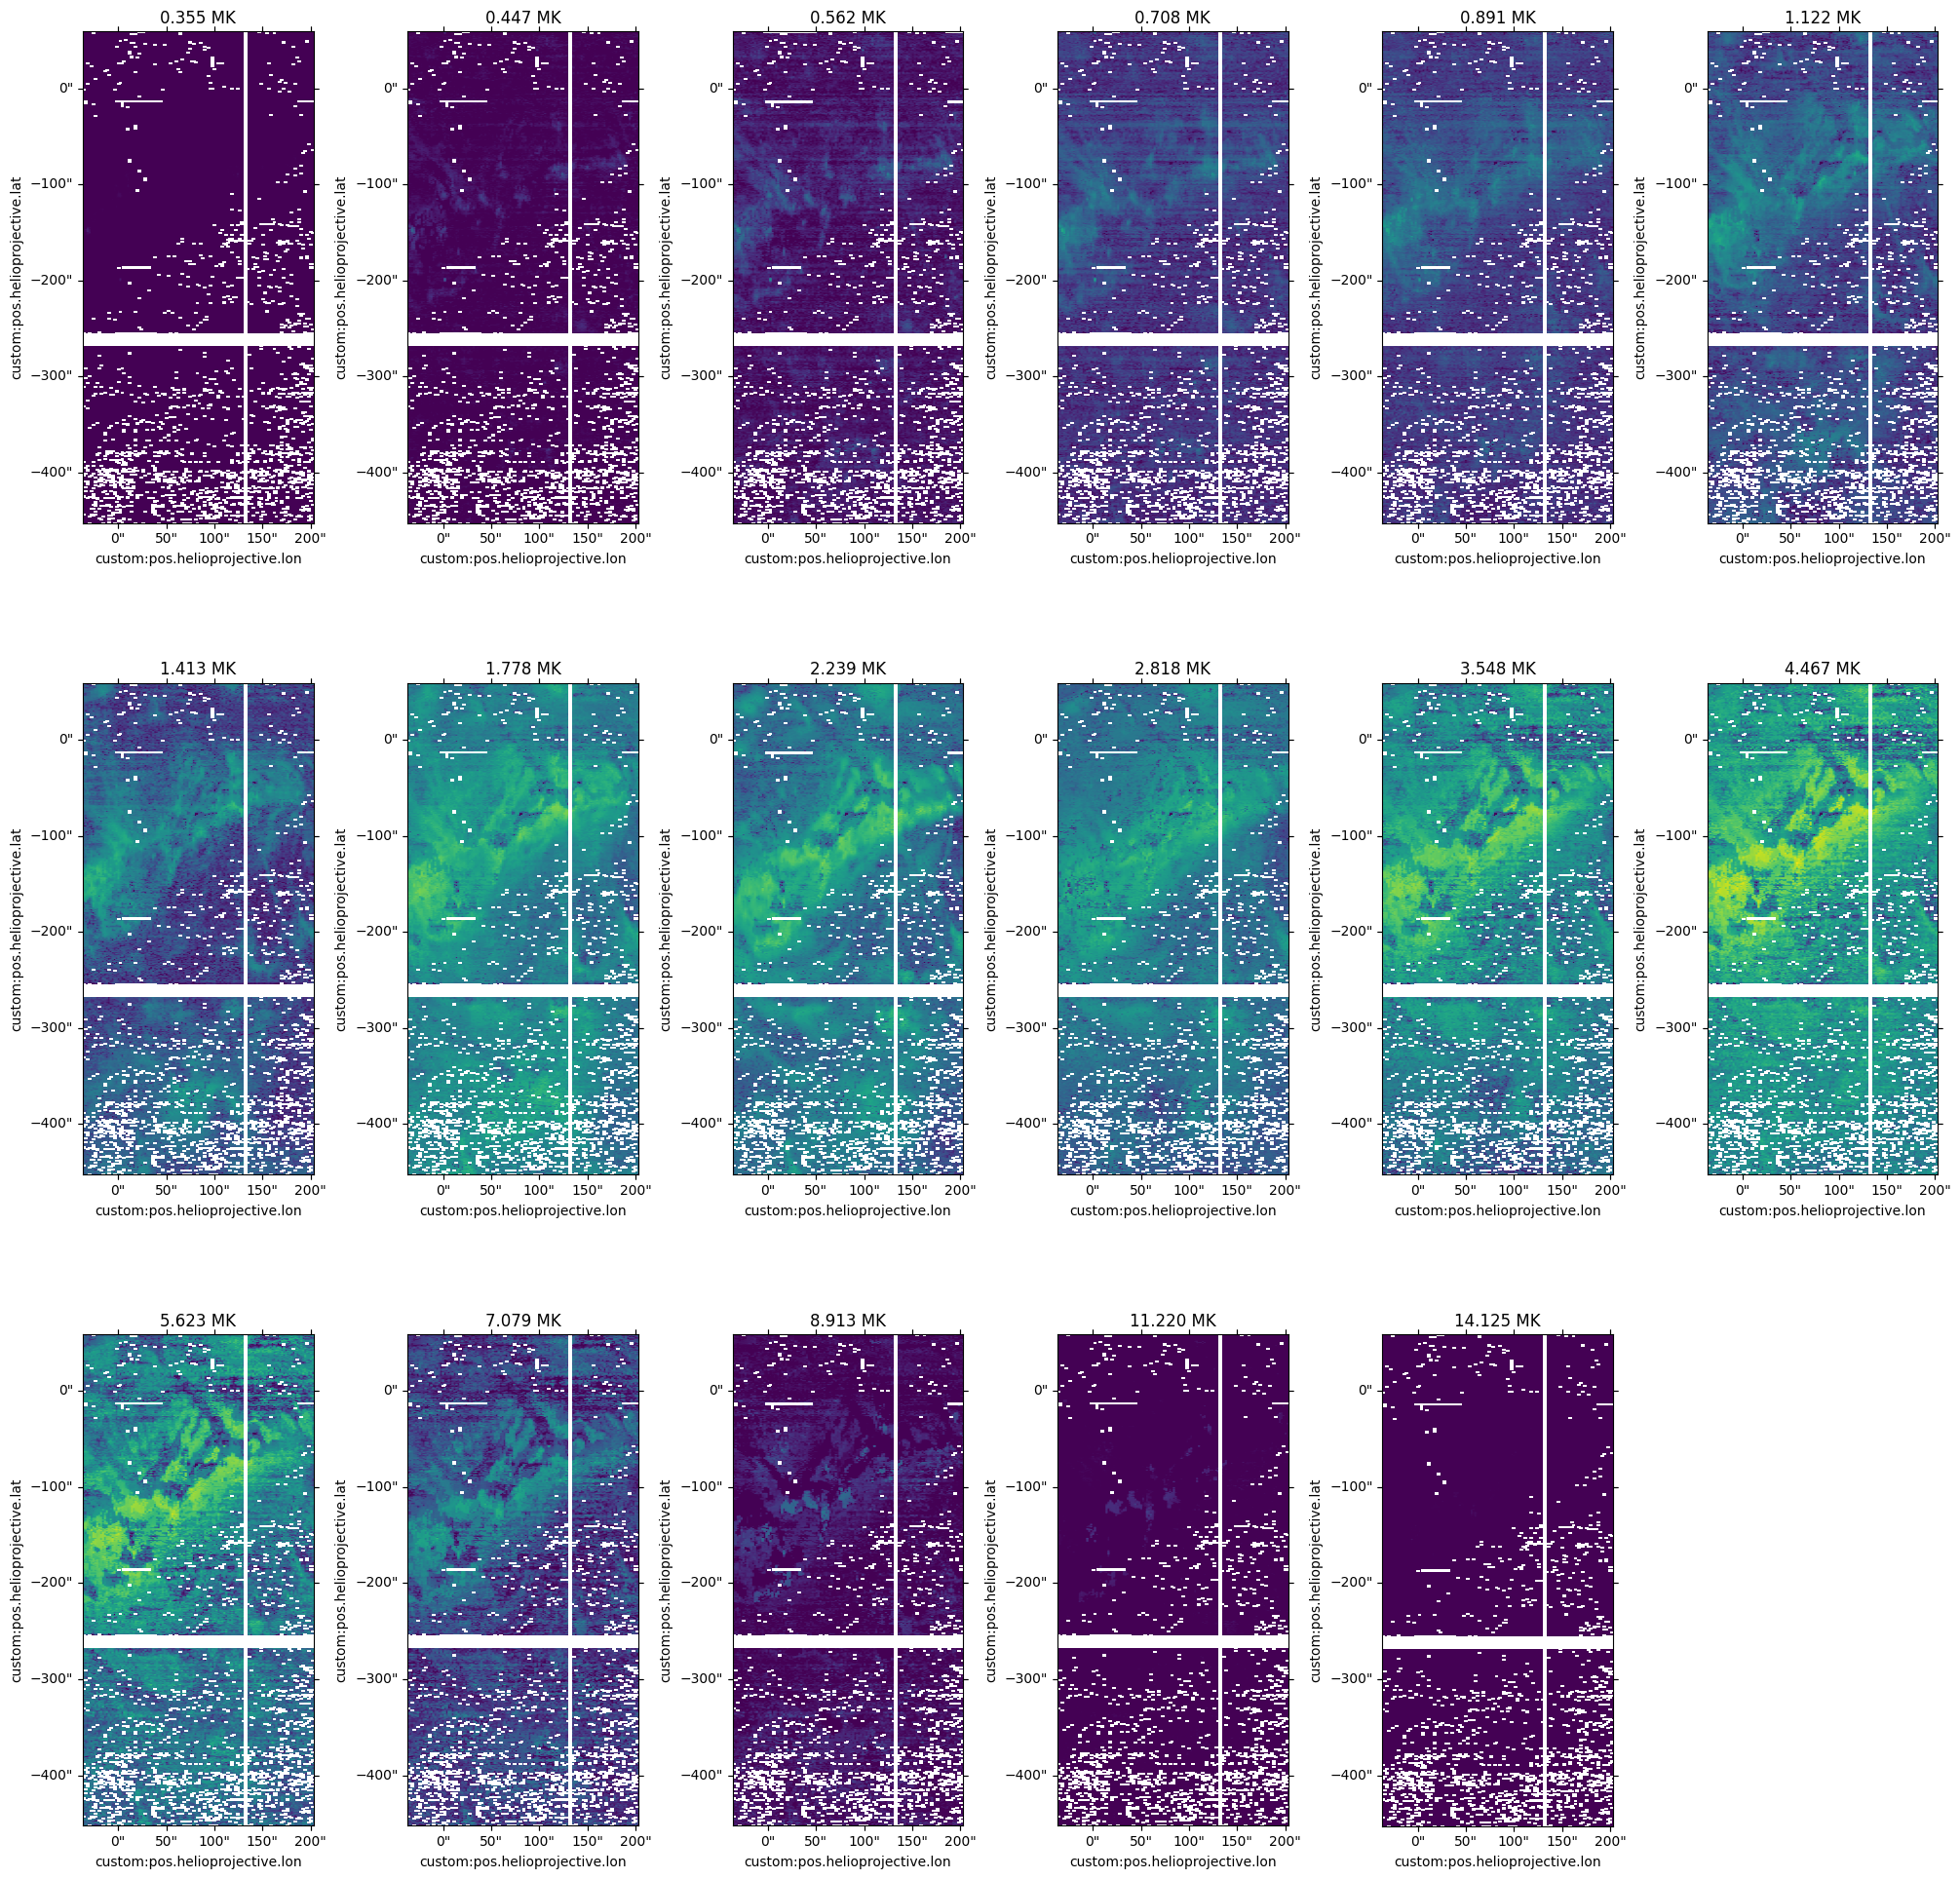

In [73]:
fig = plt.figure(figsize=(20,20),layout='constrained')
norm = ImageNormalize(vmin=1e24, vmax=1e28, stretch=LogStretch())
for i in range(len(temperature_bin_edges)-1):
    ax = fig.add_subplot(3,6,i+1,projection=dem_res_11944['em'][i,...].wcs)
    dem_res_11944['em'][i,...].plot(axes=ax,norm=norm)
    #ax.imshow(dem_res_11944['em'][i,...].data, norm=norm, origin='lower')
    ax.set_aspect(0.5)
    ax.set_title(f"{dem_model_11944.temperature_bin_centers[i].to('MK'):.3f}")

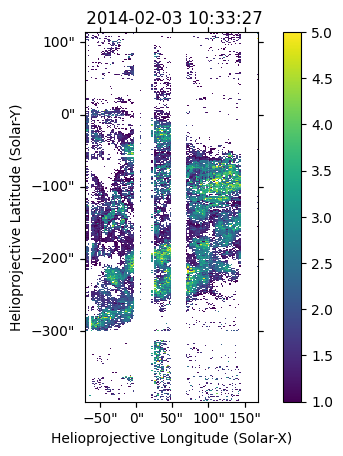

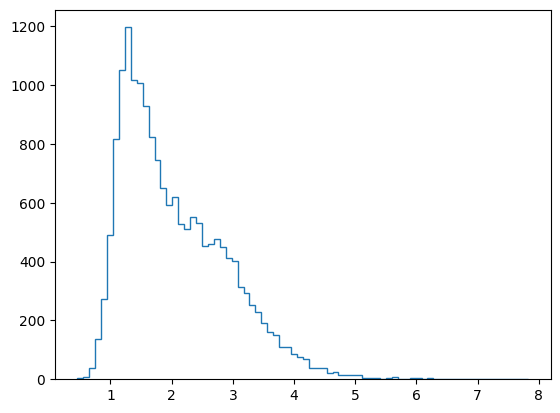

In [91]:
with asdf.open('../data/noaa_11967/diagnostics/dem/emslope_noaa11967_eis.asdf', lazy_load=False) as af:
    _sm = af['slope_map']
#_sm.mask = None
_sm.peek(vmin=1, vmax=5, cmap='viridis', aspect=_sm.scale[1]/_sm.scale[0])
plt.hist(_sm.data[~_sm.mask], bins='fd', histtype='step');

In [38]:
em_1d = dem_res_11944['em'].rebin((1,)+dem_res_11944['em'].data.shape[1:])[:,0,0]

In [39]:
em_1d

NDCube
------
Dimensions: [17.] pix
Physical Types of Axes: [(np.str_('phys.temperature'),)]
Unit: 1 / cm5
Data Type: float64

(500000.0, 20000000.0)

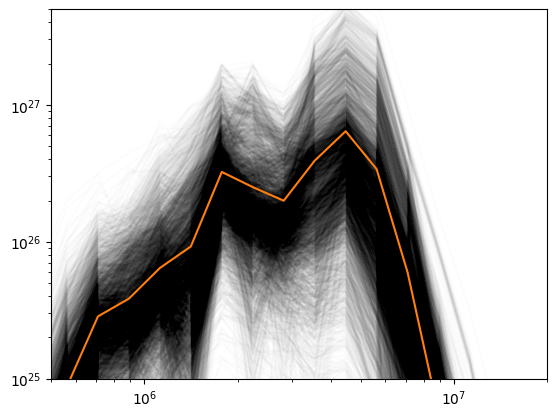

In [40]:
_sh = dem_res_11944['em'].data.shape
for _em in dem_res_11944['em'].data.reshape(_sh[:1]+(_sh[1]*_sh[2],)).T[::10]:
    plt.plot(dem_model_11944.temperature_bin_centers,_em, color='k', alpha=0.01)
plt.plot(dem_model_11944.temperature_bin_centers,em_1d.data, color='C1')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e25, 5e27)
plt.xlim(.5e6,2e7)

## Scratch Work

In [29]:
#delta_log_T = 0.02
#temperature = 10**np.arange(5.0, 7.3+delta_log_T, delta_log_T)*u.K
#density = 1e15*u.Unit('K cm-3') / temperature
#ca_17 = fiasco.Ion('Ca XVII', temperature)

In [30]:
selected_ions

{'Ca 14': CHIANTI Database Ion
 ---------------------
 Name: Ca 14
 Element: calcium (20)
 Charge: +13
 Number of Levels: 91
 Number of Transitions: 3747
 
 Temperature range: [0.100 MK, 19.953 MK]
 
 HDF5 Database: /Users/wtbarnes/Documents/projects/chianti/database/CHIANTI_v8.0.7/dbase.h5
 Using Datasets:
   ioneq: chianti
   abundance: sun_coronal_1992_feldman_ext
   ip: chianti,
 'Ca 15': CHIANTI Database Ion
 ---------------------
 Name: Ca 15
 Element: calcium (20)
 Charge: +14
 Number of Levels: 46
 Number of Transitions: 421
 
 Temperature range: [0.100 MK, 19.953 MK]
 
 HDF5 Database: /Users/wtbarnes/Documents/projects/chianti/database/CHIANTI_v8.0.7/dbase.h5
 Using Datasets:
   ioneq: chianti
   abundance: sun_coronal_1992_feldman_ext
   ip: chianti,
 'Ca 16': CHIANTI Database Ion
 ---------------------
 Name: Ca 16
 Element: calcium (20)
 Charge: +15
 Number of Levels: 204
 Number of Transitions: 5327
 
 Temperature range: [0.100 MK, 19.953 MK]
 
 HDF5 Database: /Users/wtbar

In [31]:
goft_ca17 = selected_ions['Ca 17'].contribution_function(1e9*u.cm**(-3))
goft_ca17_cp = selected_ions['Ca 17'].contribution_function(density,
                                                            couple_density_to_temperature=True)

In [32]:
transitions = selected_ions['Ca 17'].transitions.wavelength[~selected_ions['Ca 17'].transitions.is_twophoton]
i_sel = np.argmin(np.fabs(transitions - 192.858*u.AA))

In [ ]:
from astropy.visualization import 

(1000000.0, 50000000.0)

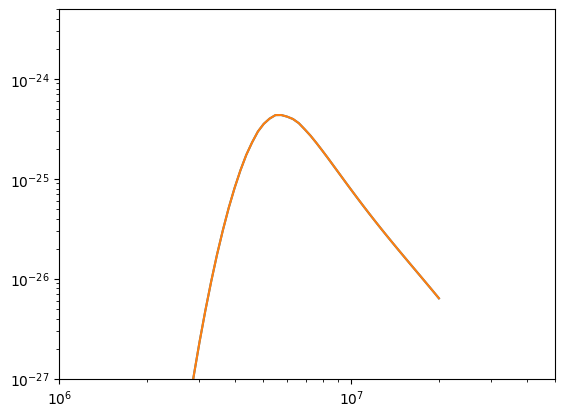

In [33]:
plt.plot(ca_17.temperature, goft_ca17[:,0,i_sel])
plt.plot(ca_17.temperature, goft_ca17_cp[:,0,i_sel])
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-27, 5e-24)
plt.xlim(1e6,5e7)

In [15]:
transitions.shape

(3252,)